implement and compare:
- Decision tree
- Naive Bayes
- K-means clustering
- DBSCAN

sklearn only:
- Multi-layer Perceptron
- KNN
- SVM
- Random Forest
- Agglomerative Clustering

classification metrics:
- precision
- recall
- F1-score
- accuracy
- confusion matrix (if possible using graph approach)

clustering metrics:
- homogeneity
- completeness

for each algorithm:
- metrics on all features with train-test split via hyperparameter performance graphs
- commentary and comparison with other algorithms in same class (classification or clustering), and especially comparing sklearn to Simple*

In [1]:
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from scipy.stats import mode

import numpy as np

from DecisionTree import *
from NaiveBayes import *
from KMeans import *
from DBSCAN import *

In [2]:
iris = load_iris()

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [5]:
# modified from:
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
def plot_data_classified(classifier = None):
  plot_colors = "ryb"
  plot_step = 0.02
  n_classes = 3

  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # subplots
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)

    # optional classifier for optional decision boundary
    if classifier is not None:
      clf = classifier().fit(X, y) # train
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(
          np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
      )
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )
  
  fig = plt.gcf()
  fig.set_size_inches(18, 9)
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.axis("tight")

  plt.show()

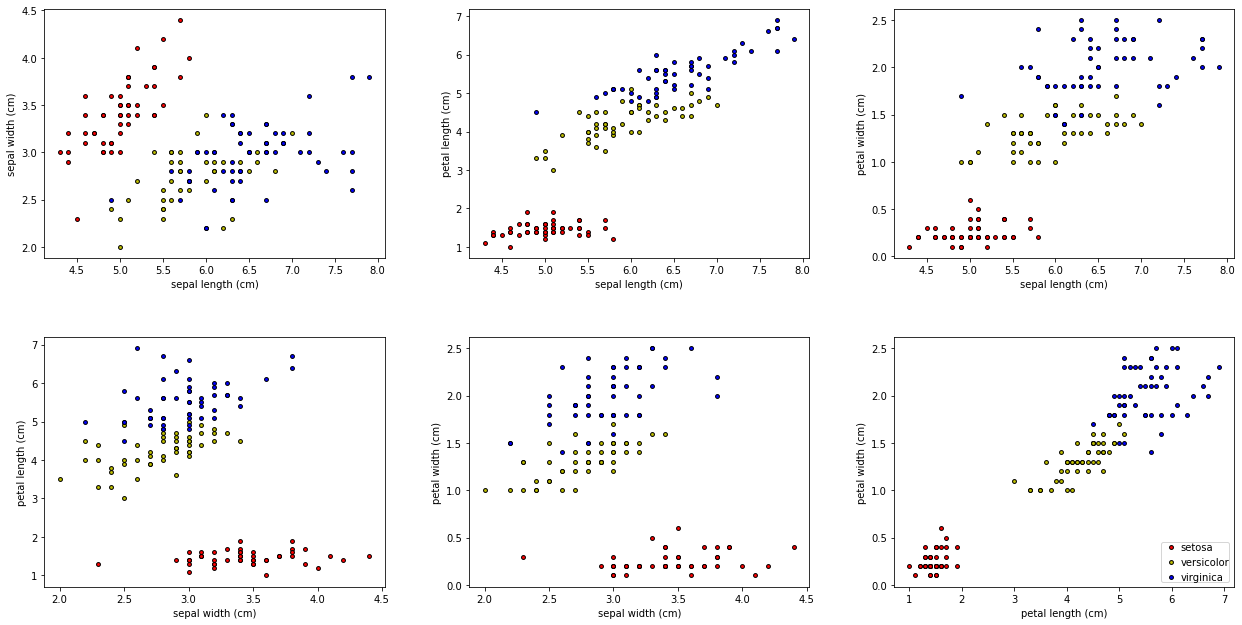

In [6]:
plot_data_classified()

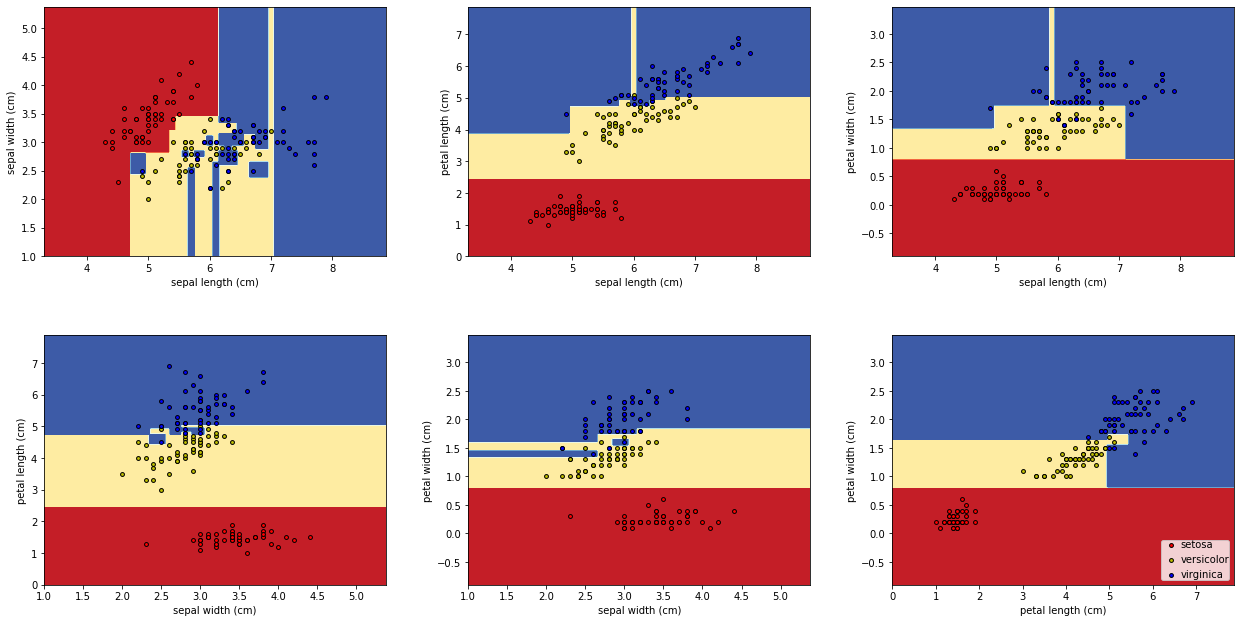

In [7]:
# decision tree
plot_data_classified(DecisionTreeClassifier)

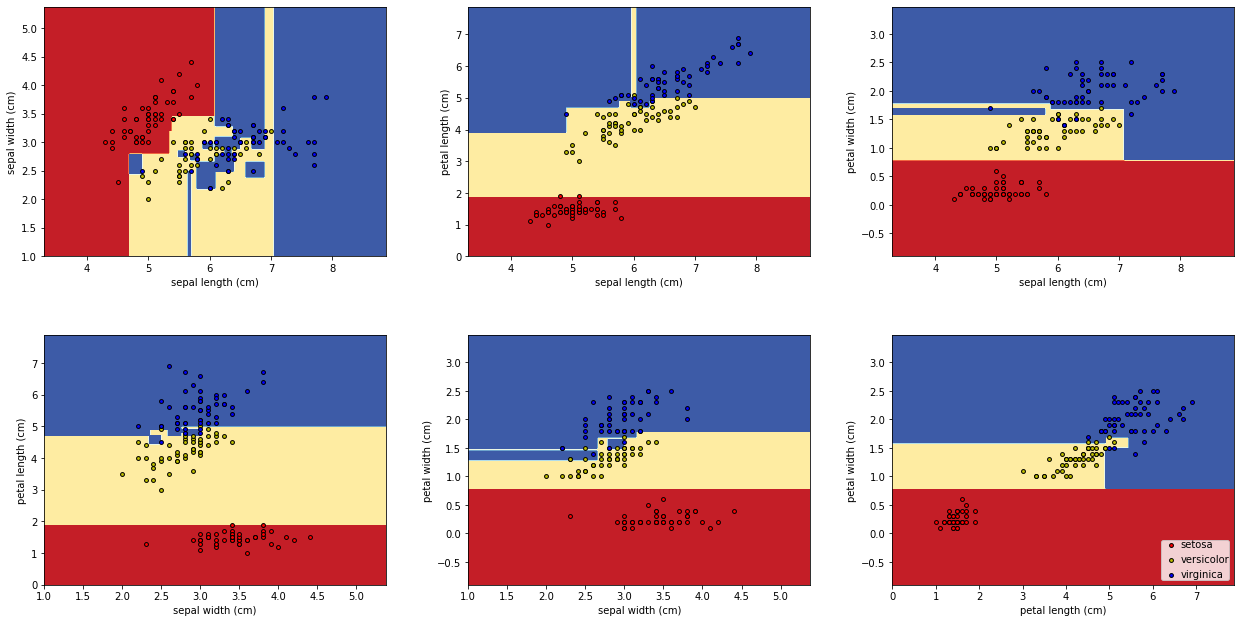

In [8]:
plot_data_classified(SimpleDecisionTree)

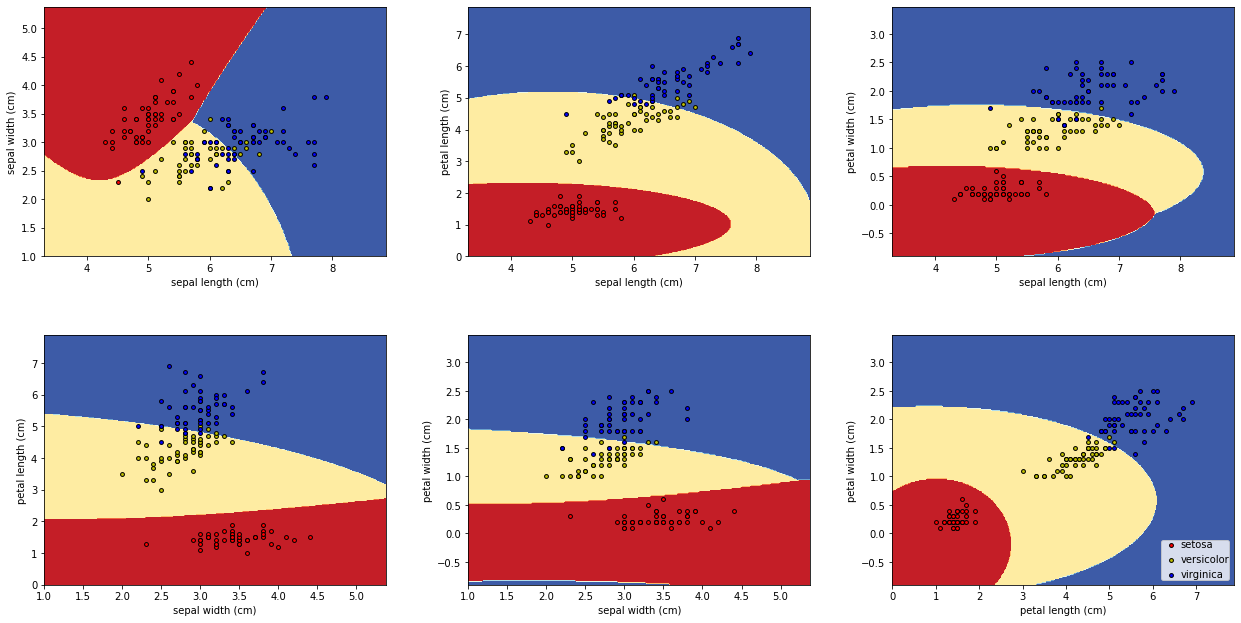

In [9]:
# naive bayes
plot_data_classified(GaussianNB)

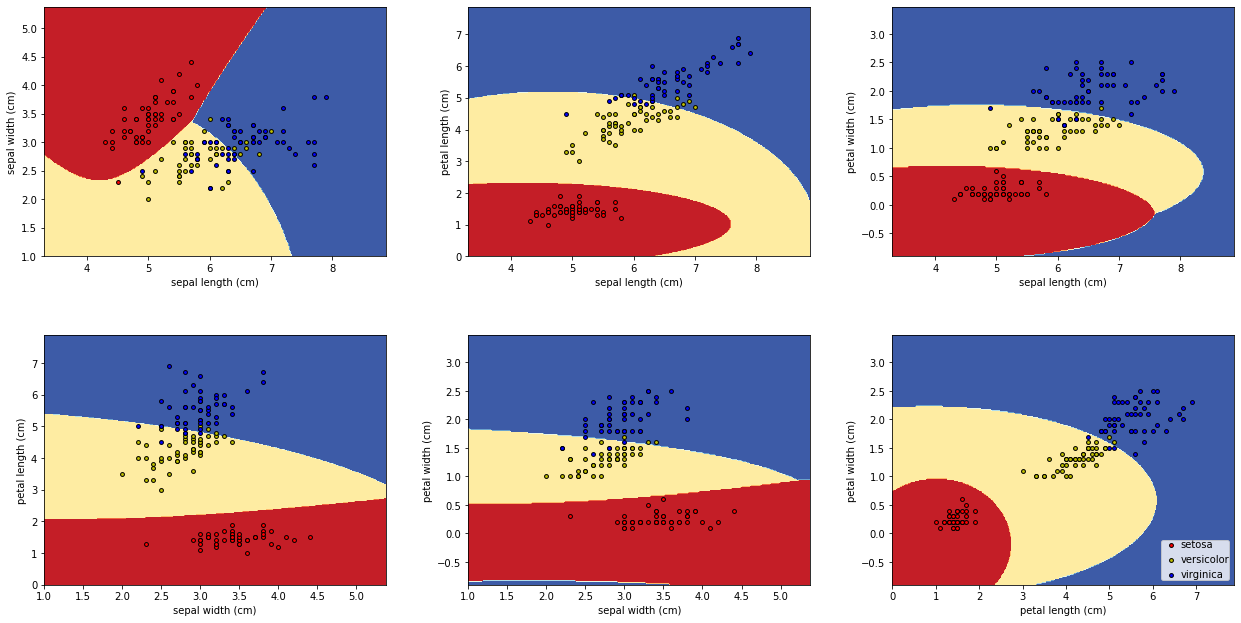

In [10]:
plot_data_classified(SimpleNaiveBayes)

/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/sit

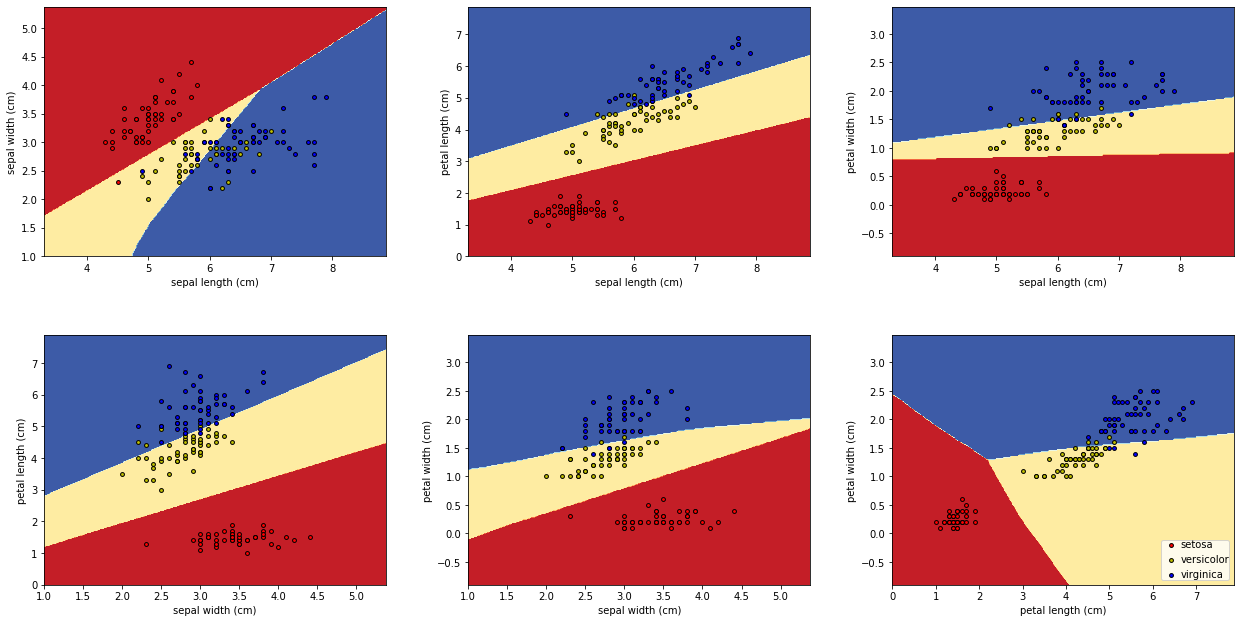

In [11]:
# multi-layer perceptron
plot_data_classified(MLPClassifier)

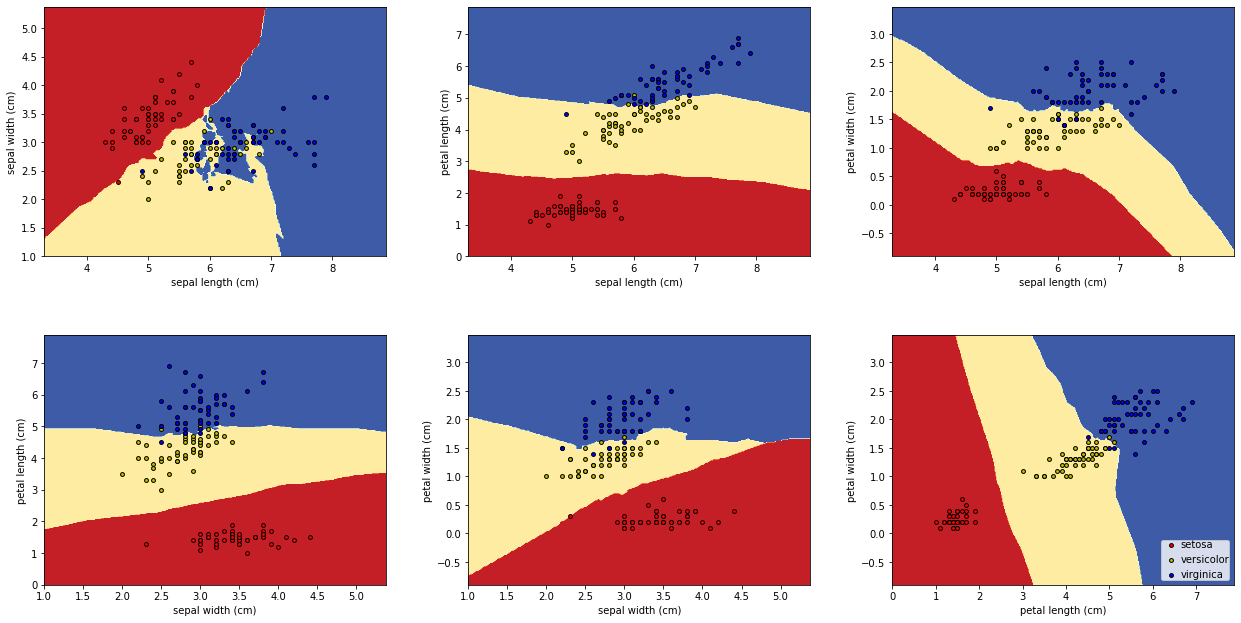

In [12]:
# k nearest neighbors
plot_data_classified(KNeighborsClassifier)

/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jhigginbotham64/.cache/pypoetry/virtualenvs/csce-5380-project-Qq8at8oe-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


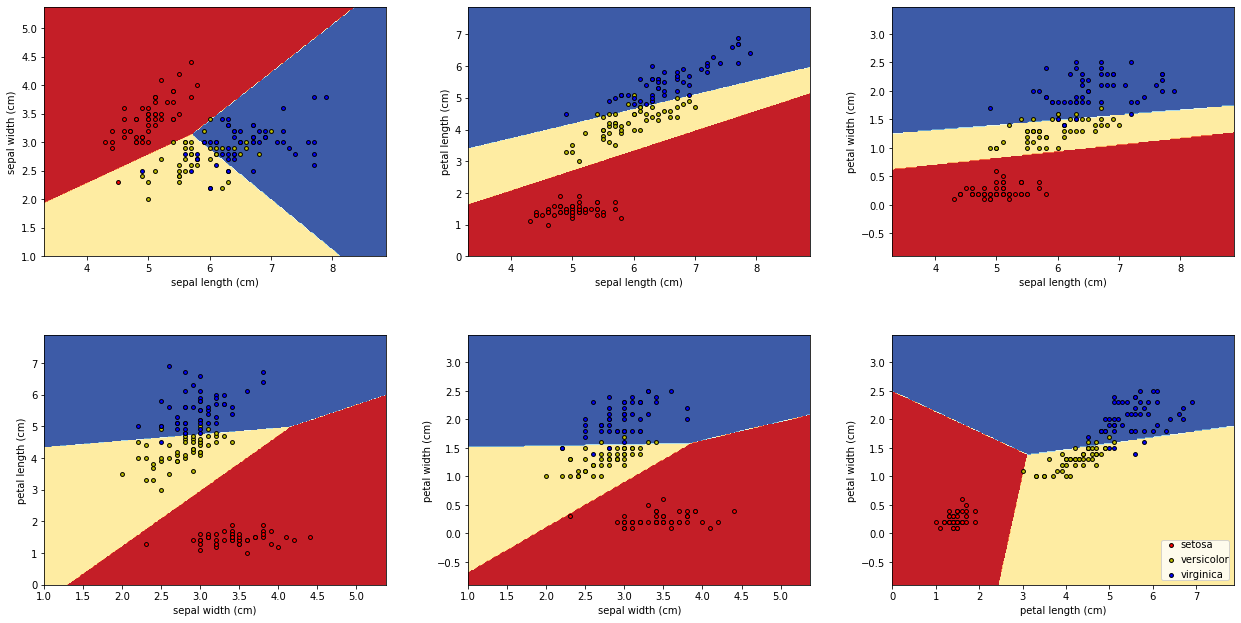

In [13]:
# support vector machine
plot_data_classified(LinearSVC)

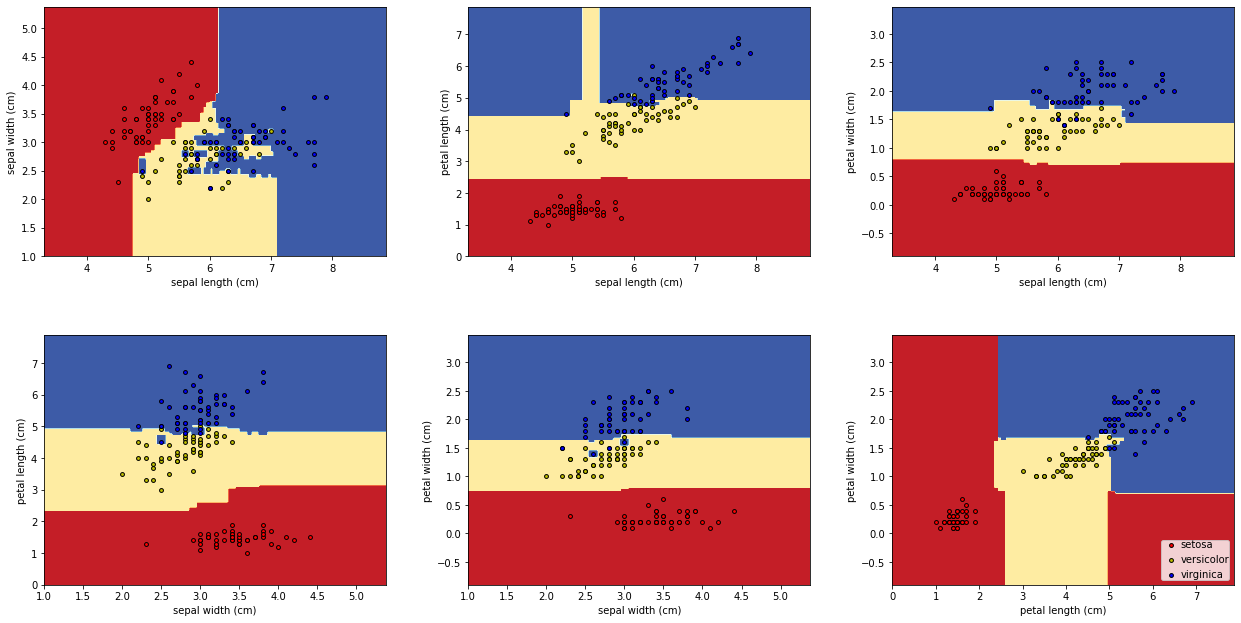

In [14]:
# random forest
plot_data_classified(RandomForestClassifier)

In [15]:
def plot_data_clustered(clusterer = None):
  plot_colors = "ryb"
  plot_step = 0.02
  n_classes = 3

  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # subplots
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)

    # optional clusterer for optional cluster labels
    if clusterer is not None:
      plt.scatter(
          X[:, 0], 
          X[:, 1], 
          c=clusterer.fit_predict(X), 
          cmap=plt.cm.RdYlBu, 
          s=120, 
          edgecolor="black"
      )

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )
  
  fig = plt.gcf()
  fig.set_size_inches(18, 9)
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.axis("tight")

  plt.show()

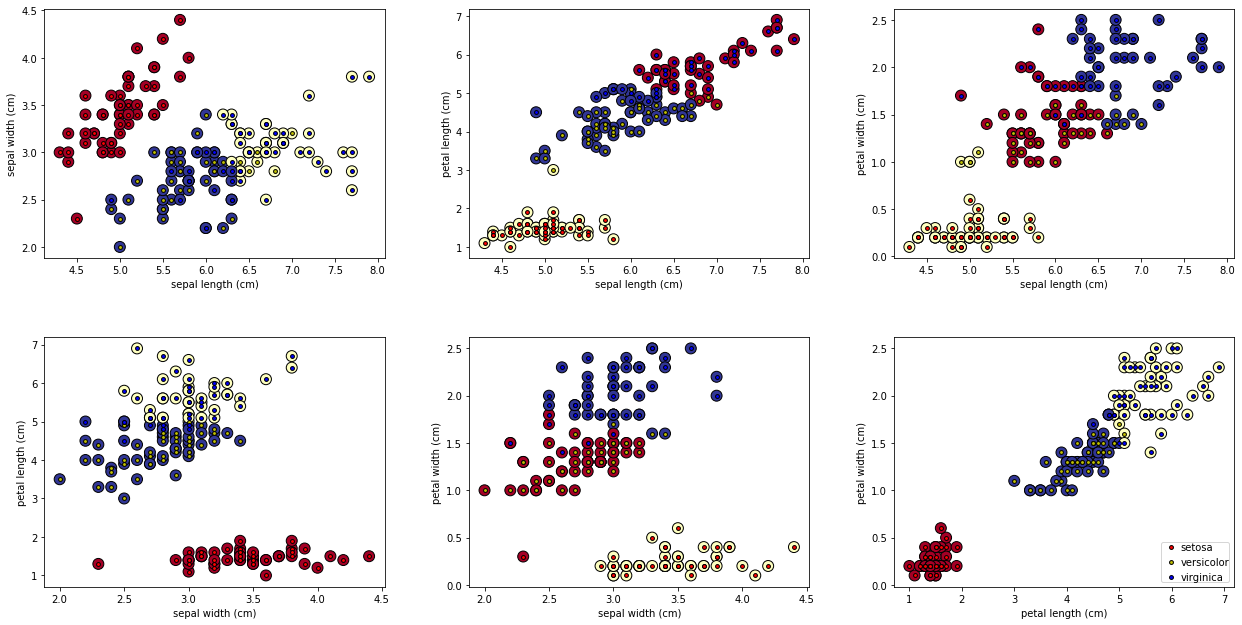

In [16]:
# k means
plot_data_clustered(KMeans(n_clusters=3))

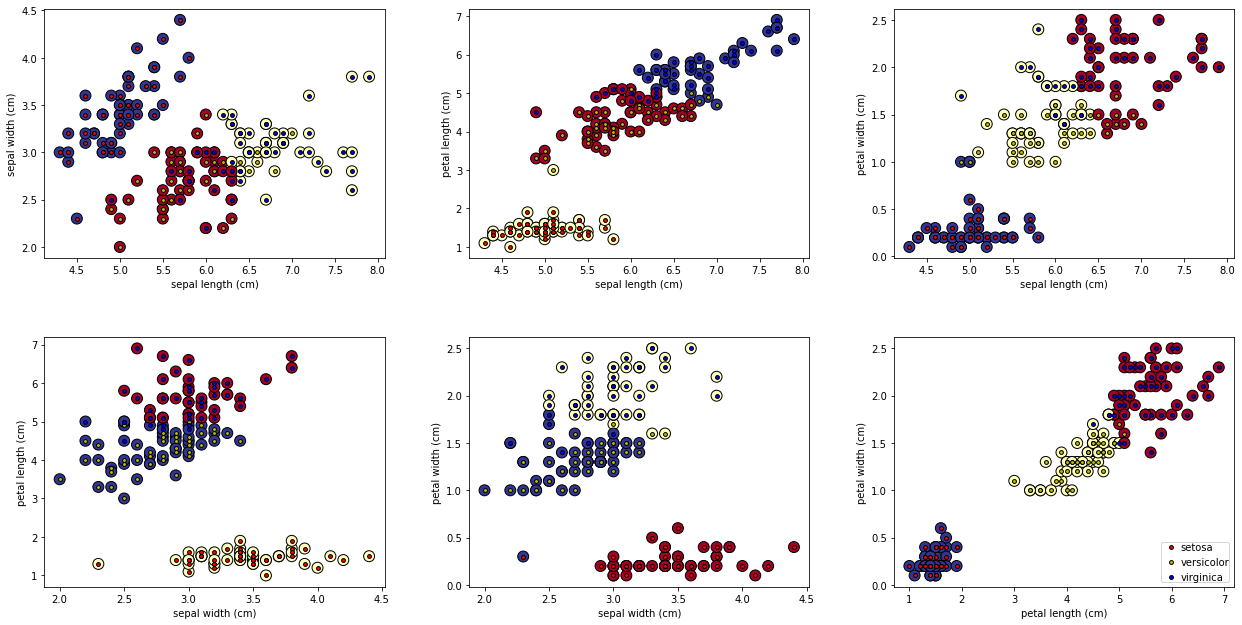

In [17]:
plot_data_clustered(SimpleKMeans(n_clusters=3))

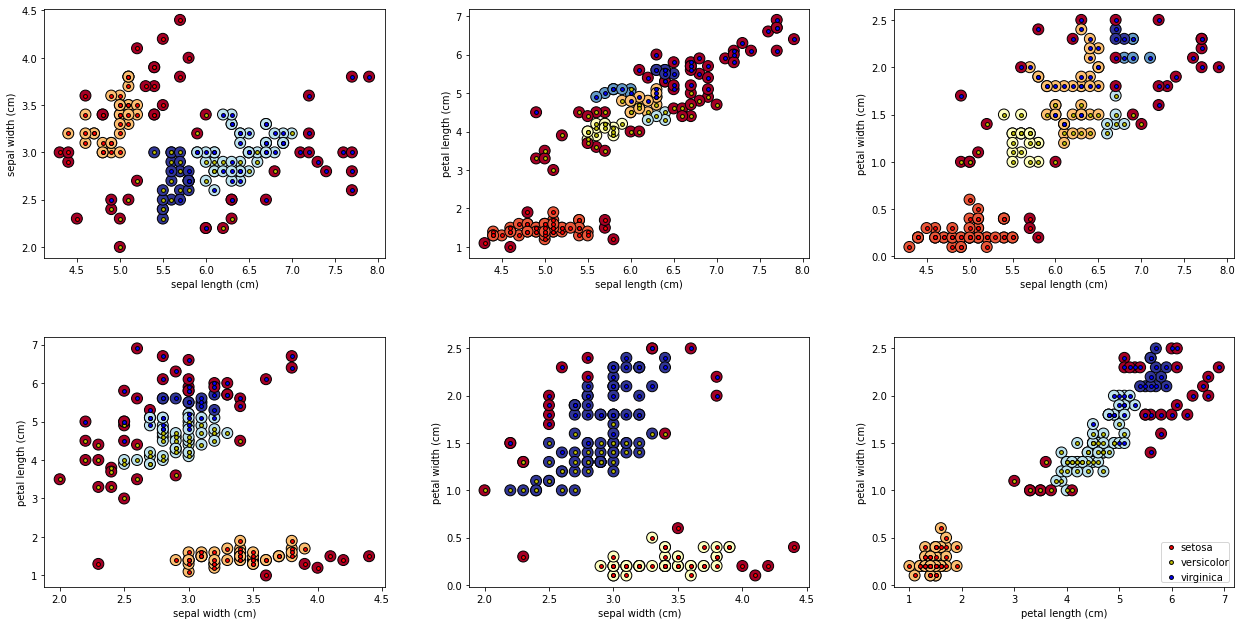

In [18]:
# DBSCAN
plot_data_clustered(DBSCAN(eps=0.2))

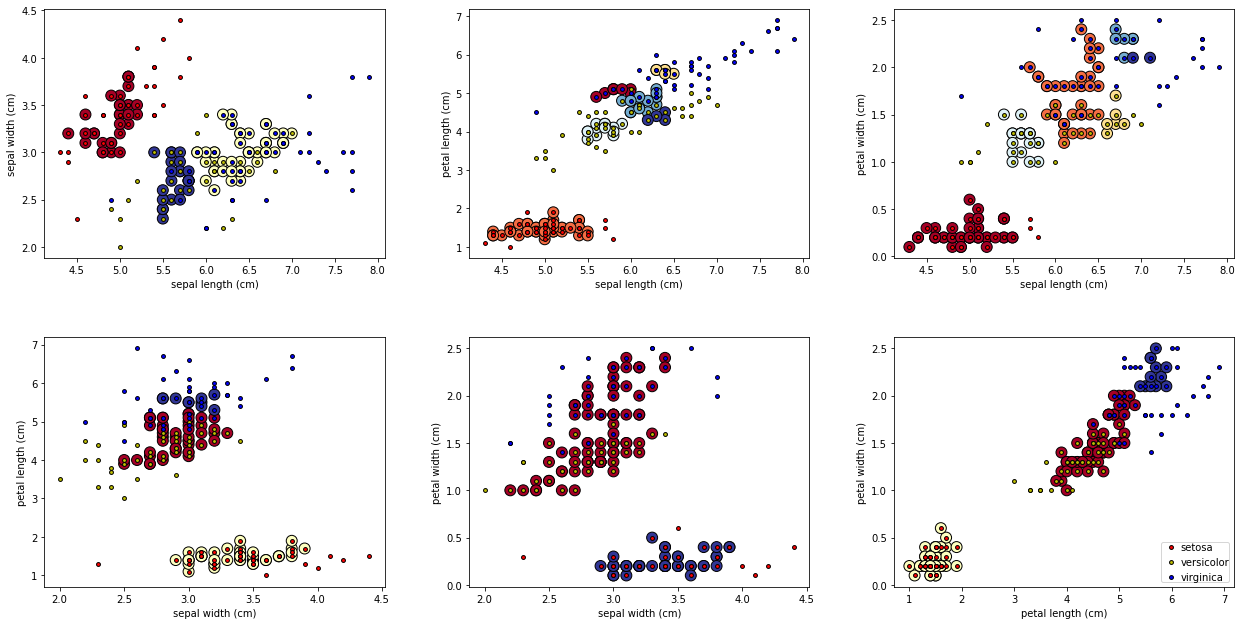

In [19]:
plot_data_clustered(SimpleDBSCAN(eps=0.2))

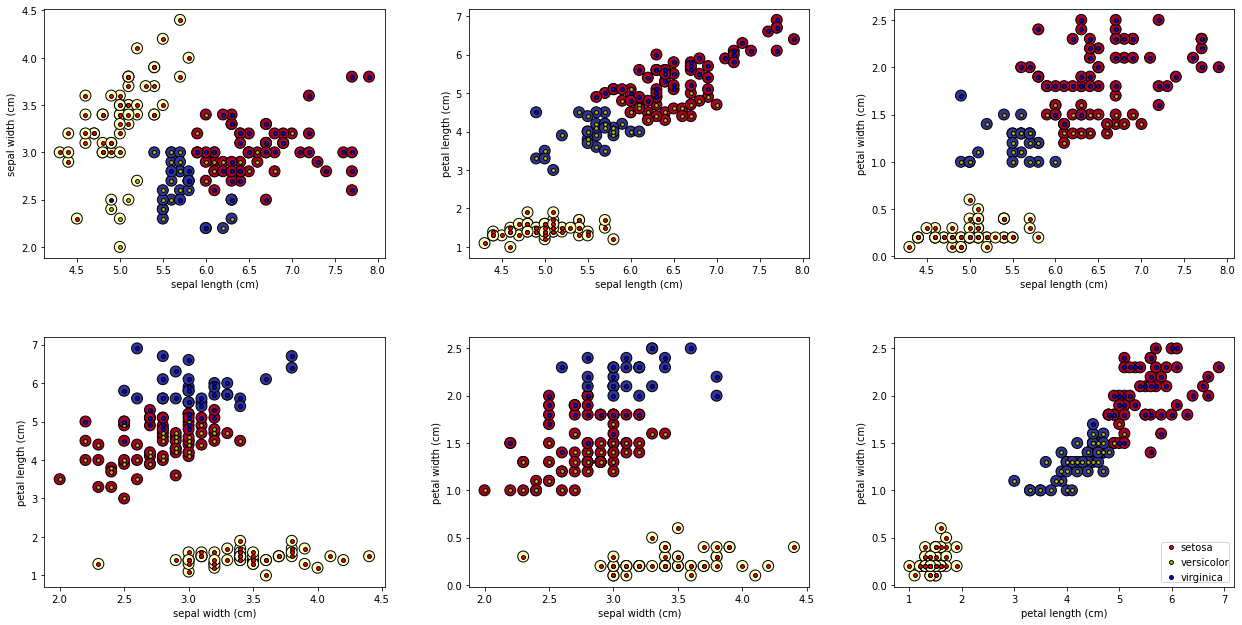

In [20]:
# agglomerative clustering
plot_data_clustered(AgglomerativeClustering(n_clusters=3))